# Data Preprocessing

This notebook details the data preprocessing steps from raw tabular data in electronic health records to text sequences. The relational database was obtained from [PhysioNet](https://physionet.org/content/mimiciv/1.0/).

## Data Querying

Download MIMIC-IV v1.0 dataset, query the information correctly to reduce the dataset to a table containing: patients identifiers, admission identifiers, admission and discharge date-times, marital status, etnicity, gender, anchor_age, codes or medical information, clinician's importance on codes, and any variables of interest.

![EHR_data](example_data.png)

## Pre-training Datasets

### Sequence creation (FULL VISIT)

In [ ]:
import os
import re
import functools
import numpy as np
import pandas as pd
try:
    import cPickle as pickle
except:
    import pickle

In [27]:
# Load data
pid_data_directory = './MIMIC-IV/PID_DEMOGRAPHIC/pid_data_hosp.pkl'
with open(pid_data_directory, 'rb') as f:
    pid_data = pickle.load(f)

In [28]:
# Total number of patients
pids = pid_data.subject_id.unique()
len(pids)

256587

In [29]:
# Find recurrent patients
recurrent = pid_data.groupby('subject_id')['hadm_id'].nunique().reset_index()
recurrent = recurrent[recurrent.hadm_id > 1]
recurrent = set(recurrent.subject_id)
recurrent_pids = list(recurrent)

In [30]:
import random
from sklearn.model_selection import train_test_split

random.seed(12345)

pretrain_size = int(len(pids) - 50000)
fine_size = int(50000)

mlm_pids, fine_pids = train_test_split(pids, test_size=fine_size / len(pids), random_state=12345)
train_mlm_pids, val_mlm_pids = train_test_split(mlm_pids, test_size=0.1, random_state=12345)
test_mlm_pids = fine_pids

It is too slow to do this loop, so we do parallel processing:

In [32]:
%%time
print('Building patients sequences...')
import re
import random
import multiprocessing

def pid_seq_picut(pid):
    group = pid_data[pid_data['subject_id'].isin([pid])]
    full_seq = []
    diag_seq = []
    input_full_seq = []
    had_stroke = max(group['had_stroke'])
    hospitalized = max(group['hospitalized'])
    died = max(group['died'])
    num_visits = 0

    regexp_dia9 = re.compile(r'DIA9_')
    regexp_dia10 = re.compile(r'DIA10_')

    patient_demographic = " " + group['anchor_age'].unique()[0] + " " + group['marital_status'].unique()[0] + " " + group['ethnicity'].unique()[0] + " " + group['gender'].unique()[0]
    patient_demographic = re.sub(' +', ' ', patient_demographic)

    for time, subgroup in group.sort_values(['dischtime','seq_num'], 
                                            ascending=True).groupby('dischtime', sort=False):
        num_visits += 1
        code_list = np.array(subgroup['med_code'].drop_duplicates()).tolist()

        if len(code_list) > 1:
            code_lm = ''
            diag_code = ''
            for code in code_list:
                code_lm += code + ' '
                if regexp_dia9.search(code) or regexp_dia10.search(code):
                    diag_code += code + ' '
        else:
            code_lm = code_list[0] + ' '
            diag_code = ''
            if regexp_dia9.search(code_list[0]) or regexp_dia10.search(code_list[0]):
                diag_code += code_list[0] + ' '
            else:
                diag_code += ' '

        code_lm = code_lm[:-1]
        diag_code = diag_code[:-1]
        full_seq.append(code_lm)
        diag_seq.append(diag_code)
        # if num_visits % 3 != 0:
        input_full_seq.append(code_lm)
    
    visits = ' & '.join(full_seq)
    input_visits = ' & '.join(input_full_seq)
    output_text = ' & '.join(diag_seq)

    input_text = "PID:" + patient_demographic + " $ " + input_visits

    return {'id': pid, 'demographic_info': patient_demographic, 'original_text': visits, 'input_text': input_text, 'output_text': output_text}

# Train Pretrain
with multiprocessing.Pool(processes=80) as pool_obj:
    print('Building train pretrain normal patients sequences...')
    train_mlm_pid_seq = pool_obj.map(pid_seq_picut, train_mlm_pids)

# Validation Pretrain
with multiprocessing.Pool(processes=80) as pool_obj:
    print('Building validation pretrain normal patients sequences...')
    val_mlm_pid_seq = pool_obj.map(pid_seq_picut, val_mlm_pids)

# Test Pretrain
with multiprocessing.Pool(processes=80) as pool_obj:
    print('Building test pretrain normal patients sequences...')
    test_mlm_pid_seq = pool_obj.map(pid_seq_picut, test_mlm_pids)

Building patients sequences...
Building train pretrain normal patients sequences...
Building validation pretrain normal patients sequences...
Building test pretrain normal patients sequences...
CPU times: user 4.26 s, sys: 22.2 s, total: 26.5 s
Wall time: 3min 34s


In [33]:
# Write out the data
out_directory = './MIMIC-IV/PID_Sequences'

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

# Preprocessed Patients Sequences
with open(out_directory + '/train_mlm_pid_seq.pkl', 'wb') as f:
    pickle.dump(train_mlm_pid_seq, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(out_directory + '/val_mlm_pid_seq.pkl', 'wb') as f:
    pickle.dump(val_mlm_pid_seq, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(out_directory + '/test_mlm_pid_seq.pkl', 'wb') as f:
    pickle.dump(test_mlm_pid_seq, f, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
# Load Patient Sequences
out_directory = './MIMIC-IV/PID_Sequences'

with open(out_directory + '/train_mlm_pid_seq.pkl', 'rb') as f:
    train_mlm_pid_seq = pickle.load(f)

with open(out_directory + '/val_mlm_pid_seq.pkl', 'rb') as f:
    val_mlm_pid_seq = pickle.load(f)

with open(out_directory + '/test_mlm_pid_seq.pkl', 'rb') as f:
    test_mlm_pid_seq = pickle.load(f)

In [48]:
print('Splitting pretraining and fine-tuning datsets...')
from sklearn.model_selection import train_test_split

pretrain_mlm_pids = [*train_mlm_pid_seq, *val_mlm_pid_seq, *test_mlm_pid_seq]

Splitting pretraining and fine-tuning datsets...


In [49]:
train_mlm_pid_seq[random.randint(1, len(train_mlm_pid_seq))]

{'id': 14029653,
 'demographic_info': ' 51 years old married white female',
 'original_text': 'DIA9_2189 PRO9_6859 DIA9_6262 DIA9_V103 2 Hematology Blood abnormal {Hematocrit}',
 'input_text': 'PID: 51 years old married white female $ DIA9_2189 PRO9_6859 DIA9_6262 DIA9_V103 2 Hematology Blood abnormal {Hematocrit}',
 'output_text': 'DIA9_2189 DIA9_6262 DIA9_V103'}

In [50]:
print('Pre-train datasets:')
print(f'Training size: {len(train_mlm_pid_seq)} ({round(len(train_mlm_pid_seq) / len(pretrain_mlm_pids), 2) * 100}%)')
print(f'Validation size: {len(val_mlm_pid_seq)} ({round(len(val_mlm_pid_seq) / len(pretrain_mlm_pids), 2) * 100}%)\n')
print(f'Test size: {len(test_mlm_pid_seq)} ({round(len(test_mlm_pid_seq) / len(pretrain_mlm_pids), 2) * 100}%)\n')

Pre-train datasets:
Training size: 185928 (90.0%)
Validation size: 10330 (5.0%)

Test size: 10329 (5.0%)



In [51]:
import pickle
from tqdm.auto import tqdm

def create_text_seq(data, txt_dir):
    text_data = []
    file_count = 0

    for sample in tqdm(data):
        text_data.append(sample['demographic_info'])
        text_data.append(sample['original_text'])
        if len(text_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(txt_dir):
                os.makedirs(txt_dir)
            with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1
            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:
        with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(text_data)} patients")

def create_pid_seq(data, pid_dir, protocol=pickle.HIGHEST_PROTOCOL):
    pid_data = []
    file_count = 0

    for sample in tqdm(data):

        pid_data.append(sample)

        if len(pid_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(pid_dir):
                os.makedirs(pid_dir)

            with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
                pickle.dump(pid_data, f, protocol=protocol)

            pid_data = []
            file_count += 1

            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:

        with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
            pickle.dump(pid_data, f, protocol=protocol)

        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(pid_data)} patients")

Create training and validation datasets:

In [52]:
# Pretrain
create_pid_seq(data=train_mlm_pid_seq, pid_dir="./MIMIC-IV/PID_Sequences/Pretrain/train")
create_pid_seq(data=val_mlm_pid_seq, pid_dir="./MIMIC-IV/PID_Sequences/Pretrain/validation")
create_pid_seq(data=test_mlm_pid_seq, pid_dir="./MIMIC-IV/PID_Sequences/Pretrain/test")
create_text_seq(data=train_mlm_pid_seq, txt_dir="./MIMIC-IV/PID_Sequences/Pretrain/train/txt_files")

  0%|          | 0/185928 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 15000 patients
Saved 20000 patients
Saved 25000 patients
Saved 30000 patients
Saved 35000 patients
Saved 40000 patients
Saved 45000 patients
Saved 50000 patients
Saved 55000 patients
Saved 60000 patients
Saved 65000 patients
Saved 70000 patients
Saved 75000 patients
Saved 80000 patients
Saved 85000 patients
Saved 90000 patients
Saved 95000 patients
Saved 100000 patients
Saved 105000 patients
Saved 110000 patients
Saved 115000 patients
Saved 120000 patients
Saved 125000 patients
Saved 130000 patients
Saved 135000 patients
Saved 140000 patients
Saved 145000 patients
Saved 150000 patients
Saved 155000 patients
Saved 160000 patients
Saved 165000 patients
Saved 170000 patients
Saved 175000 patients
Saved 180000 patients
Saved 185000 patients
Saved 185928 patients


  0%|          | 0/10330 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 10330 patients


  0%|          | 0/10329 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 10329 patients


  0%|          | 0/185928 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 15000 patients
Saved 20000 patients
Saved 25000 patients
Saved 30000 patients
Saved 35000 patients
Saved 40000 patients
Saved 45000 patients
Saved 50000 patients
Saved 55000 patients
Saved 60000 patients
Saved 65000 patients
Saved 70000 patients
Saved 75000 patients
Saved 80000 patients
Saved 85000 patients
Saved 90000 patients
Saved 95000 patients
Saved 100000 patients
Saved 105000 patients
Saved 110000 patients
Saved 115000 patients
Saved 120000 patients
Saved 125000 patients
Saved 130000 patients
Saved 135000 patients
Saved 140000 patients
Saved 145000 patients
Saved 150000 patients
Saved 155000 patients
Saved 160000 patients
Saved 165000 patients
Saved 170000 patients
Saved 175000 patients
Saved 180000 patients
Saved 185000 patients
Saved 190000 patients
Saved 195000 patients
Saved 200000 patients
Saved 205000 patients
Saved 210000 patients
Saved 215000 patients
Saved 220000 patients
Saved 225000 patients
Saved 230000 patients
Saved 23

## Fine-tuning Datasets

### Sequence creation (Heart Failure Classification)

In [2]:
import os
import pandas as pd
try:
    import cPickle as pickle
except:
    import pickle

# Load data
pid_data_directory = './MIMIC-IV/PID_DEMOGRAPHIC/pid_data_hosp.pkl'
with open(pid_data_directory, 'rb') as f:
    pid_data = pickle.load(f)

In [3]:
# Total number of patients
pids = pid_data.subject_id.unique()
len(pids)

256587

In [8]:
# Find recurrent patients
recurrent = pid_data.groupby('subject_id')['hadm_id'].nunique().reset_index()
recurrent = recurrent[recurrent.hadm_id > 1]
recurrent = set(recurrent.subject_id)
recurrent_pids = list(recurrent)

In [5]:
import random
from sklearn.model_selection import train_test_split

random.seed(12345)

pretrain_size = int(len(pids) - 50000)
fine_size = int(50000)

_, fine_pids = train_test_split(pids, test_size=fine_size / len(pids), random_state=12345)

In [11]:
print('Loading ICD code tables...')

data_icd_diag = pd.read_csv('./physionet.org/files/mimiciv/1.0/hosp/d_icd_diagnoses.csv')

data_icd_diag.columns = data_icd_diag.columns.str.lower()

print(data_icd_diag.head())

print('Selecting ICD codes for classification...')
heart_failure_set = set()

############################ ICD9 ############################
# ICD9 Heart Failure for 428 branch
heart_failure_code = data_icd_diag[data_icd_diag.icd_version.isin([9]) \
                            & [True if re.search('^428', det) is not None else False for det in data_icd_diag.icd_code]]
heart_failure_code = set('DIA' + heart_failure_code.icd_version.astype(str) + '_' + heart_failure_code.icd_code.astype(str))
heart_failure_set = heart_failure_set.union(heart_failure_code)

# ICD9 Heart Failure for title name
heart_failure_code = data_icd_diag[data_icd_diag.icd_version.isin([9]) \
                            & [True if (re.search('heart failure', det) is not None) & (re.search('without heart failure', det) is None) else False for det in data_icd_diag.long_title]]
heart_failure_code = set('DIA' + heart_failure_code.icd_version.astype(str) + '_' + heart_failure_code.icd_code.astype(str))
heart_failure_set = heart_failure_set.union(heart_failure_code)

# ############################ ICD10 ############################
# ICD10 Heart Failure for I50 branch
heart_failure_code = data_icd_diag[data_icd_diag.icd_version.isin([10]) \
                            & [True if re.search('^I50', det) is not None else False for det in data_icd_diag.icd_code]]
heart_failure_code = set('DIA' + heart_failure_code.icd_version.astype(str) + '_' + heart_failure_code.icd_code.astype(str))
heart_failure_set = heart_failure_set.union(heart_failure_code)

# ICD10 Heart Failure for title name
heart_failure_code = data_icd_diag[data_icd_diag.icd_version.isin([10]) \
                            & [True if (re.search('heart failure', det) is not None) & (re.search('without heart failure', det) is None) else False for det in data_icd_diag.long_title]]
heart_failure_code = set('DIA' + heart_failure_code.icd_version.astype(str) + '_' + heart_failure_code.icd_code.astype(str))
heart_failure_set = heart_failure_set.union(heart_failure_code)

print(len(heart_failure_set))

Loading ICD code tables...
  icd_code  icd_version                             long_title
0     0010            9         Cholera due to vibrio cholerae
1     0011            9  Cholera due to vibrio cholerae el tor
2     0019            9                   Cholera, unspecified
3     0020            9                          Typhoid fever
4     0021            9                    Paratyphoid fever A
Selecting ICD codes for classification...
61


It is too slow to do this loop, so we do parallel processing:

In [12]:
%%time
print('Building patients sequences...')
import random
import multiprocessing

def pid_seq_bart_heart_failure(pid):
    group = pid_data[pid_data['subject_id'].isin([pid])]
    full_seq = []
    diag_seq = []
    had_heart_failure = 0
    num_visits = 0

    regexp_dia9 = re.compile(r'DIA9_')
    regexp_dia10 = re.compile(r'DIA10_')

    patient_demographic = " " + group['anchor_age'].unique()[0] + " " + group['marital_status'].unique()[0] + " " + group['ethnicity'].unique()[0] + " " + group['gender'].unique()[0]
    patient_demographic = re.sub(' +', ' ', patient_demographic)

    for _, subgroup in group.sort_values(['dischtime','seq_num'], 
                                            ascending=True).groupby('dischtime', sort=False):

        num_visits += 1
        code_list = np.array(subgroup['med_code'].drop_duplicates()).tolist()

        if heart_failure_set.intersection(set(code_list)) != set():
            had_heart_failure = 1
            break

        if len(code_list) > 1:
            code_lm = ''
            diag_code = ''
            for code in code_list:
                code_lm += code + ' '
                if regexp_dia9.search(code) or regexp_dia10.search(code):
                    diag_code += code + ' '
        else:
            code_lm = code_list[0] + ' '
            diag_code = ''
            # find if visit has a diagnosis related to heart failure
            if regexp_dia9.search(code_list[0]) or regexp_dia10.search(code_list[0]):
                diag_code += code_list[0] + ' '
            else:
                diag_code += ' '

        code_lm = code_lm[:-1]
        diag_code = diag_code[:-1]
        full_seq.append(code_lm)
        diag_seq.append(diag_code)
    
    visits = ' & '.join(full_seq)
    input_visits = ' & '.join(full_seq)
    output_text = ' & '.join(diag_seq)

    input_text = "PID:" + patient_demographic + " $ " + input_visits

    return {'id': pid, 'demographic_info': patient_demographic, 'original_text': visits, 'input_text': input_text, 'output_text': output_text, 'had_heart_failure': had_heart_failure}

# Finetune
with multiprocessing.Pool(processes=80) as pool_obj:
    print('Building finetune patients sequences...')
    fine_pid_seq_heart_failure = pool_obj.map(pid_seq_bart_heart_failure, fine_pids)

Building patients sequences...
Building finetune patients sequences...
CPU times: user 1.15 s, sys: 3.88 s, total: 5.03 s
Wall time: 53.5 s


In [18]:
fine_pid_seq_heart_failure[0]

{'id': 12524759,
 'demographic_info': ' 45 years old single hispanic/latino male',
 'original_text': 'DIA9_78650 PRO9_8952 DIA9_41400 PRO9_8744 PRO9_8938 PRO9_3899 1 Hematology Blood abnormal {Neutrophils} 1 Hematology Blood abnormal {Red Blood Cells} 1 Hematology Blood abnormal {MCH} 1 Chemistry Blood abnormal {Glucose} 1 Chemistry Blood abnormal {Creatine Kinase (CK)} & DIA9_5921 PRO9_560 DIA9_30390 PRO9_598 DIA9_2859 PRO9_5631 DIA9_4019 PRO9_5732 DIA9_2720 DIA9_30560 1 Hematology Blood abnormal {Hematocrit} 1 Hematology Blood abnormal {Red Blood Cells} 1 Hematology Blood abnormal {Hemoglobin} 1 Hematology Blood abnormal {MCH} 1 Hematology Blood abnormal {Platelet Count} 1 Hematology Blood abnormal {MCV} & DIA9_95901 DIA9_9100 DIA9_E8120 DIA9_30500 DIA9_4019 & DIA9_5920 DIA9_591 DIA9_4019 DIA9_7881 DIA9_2720 DIA9_30500 DIA9_V1279 DIA9_V1749',
 'input_text': 'PID: 45 years old single hispanic/latino male $ DIA9_78650 PRO9_8952 DIA9_41400 PRO9_8744 PRO9_8938 PRO9_3899 1 Hematology Bloo

In [19]:
# Write out the data
out_directory = './MIMIC-IV/PID_Sequences'

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

with open(out_directory + '/fine_pid_seq_heart_failure.pkl', 'wb') as f:
    pickle.dump(fine_pid_seq_heart_failure, f, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Load Patient Sequences
out_directory = './MIMIC-IV/PID_Sequences'

with open(out_directory + '/fine_pid_seq_heart_failure.pkl', 'rb') as f:
    fine_pid_seq_heart_failure = pickle.load(f)

In [21]:
print('Splitting pretraining and fine-tuning datsets...')
from sklearn.model_selection import train_test_split

# Fine-tune
fine_size = len(fine_pid_seq_heart_failure)

train_fine_pid_seq_heart_failure, val_test_fine_pid_seq_heart_failure = train_test_split(fine_pid_seq_heart_failure, test_size=0.2, random_state=12345)
val_fine_pid_seq_heart_failure, test_fine_pid_seq_heart_failure = train_test_split(val_test_fine_pid_seq_heart_failure, test_size=0.5, random_state=12345)

Splitting pretraining and fine-tuning datsets...


In [22]:
print('Fine-tune datasets:')
print(f'Training size: {len(train_fine_pid_seq_heart_failure)} ({round(len(train_fine_pid_seq_heart_failure) / len(fine_pid_seq_heart_failure), 2) * 100}%)')
print(f'Validation size: {len(val_fine_pid_seq_heart_failure)} ({round(len(val_fine_pid_seq_heart_failure) / len(fine_pid_seq_heart_failure), 2) * 100}%)')
print(f'Testing size: {len(test_fine_pid_seq_heart_failure)} ({round(len(test_fine_pid_seq_heart_failure) / len(fine_pid_seq_heart_failure), 2) * 100}%)')

Fine-tune datasets:
Training size: 40000 (80.0%)
Validation size: 5000 (10.0%)
Testing size: 5000 (10.0%)
Testing size: 5000 (10.0%)


In [24]:
import pickle
from tqdm.auto import tqdm

def create_text_seq(data, txt_dir):
    text_data = []
    file_count = 0

    for sample in tqdm(data):
        text_data.append(sample['demographic_info'])
        text_data.append(sample['original_text'])
        if len(text_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(txt_dir):
                os.makedirs(txt_dir)
            with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1
            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:
        with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(text_data)} patients")

def create_pid_seq(data, pid_dir, protocol=pickle.HIGHEST_PROTOCOL):
    pid_data = []
    file_count = 0

    for sample in tqdm(data):

        pid_data.append(sample)

        if len(pid_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(pid_dir):
                os.makedirs(pid_dir)

            with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
                pickle.dump(pid_data, f, protocol=protocol)

            pid_data = []
            file_count += 1

            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:

        with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
            pickle.dump(pid_data, f, protocol=protocol)

        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(pid_data)} patients")

Create training and validation datasets:

In [25]:
# Finetune
create_pid_seq(data=train_fine_pid_seq_heart_failure, pid_dir="./MIMIC-IV/PID_Sequences/Finetune_heart_failure/train")
create_pid_seq(data=val_fine_pid_seq_heart_failure, pid_dir="./MIMIC-IV/PID_Sequences/Finetune_heart_failure/validation")
create_pid_seq(data=test_fine_pid_seq_heart_failure, pid_dir="./MIMIC-IV/PID_Sequences/Finetune_heart_failure/test")

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 15000 patients
Saved 20000 patients
Saved 25000 patients
Saved 30000 patients
Saved 35000 patients
Saved 40000 patients


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 patients


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 patients


We observe the class distribution in the training dataset:

Positive class percentage: 0.1992
Class weights: [0.62437562 2.51004016]


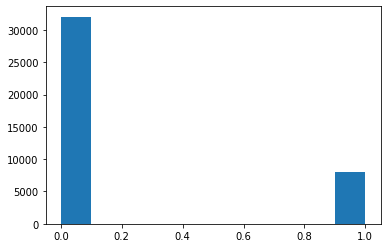

In [26]:
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

train_fine_pid_seq_heart_failure_targets = [obs['had_heart_failure'] for obs in train_fine_pid_seq_heart_failure]

classes = [val for val in range(2)]
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=train_fine_pid_seq_heart_failure_targets)

plt.hist(train_fine_pid_seq_heart_failure_targets)
print(f"Positive class percentage: {sum(train_fine_pid_seq_heart_failure_targets) / len(train_fine_pid_seq_heart_failure_targets)}")
print(f"Class weights: {class_weights}")

out_directory = "./MIMIC-IV/PID_Sequences/Finetune_heart_failure"
with open(out_directory + '/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

### Sequence creation (Three Day Hospitalization Stay Classification)

In [21]:
import os
import pandas as pd
try:
    import cPickle as pickle
except:
    import pickle

# Load data
pid_data_directory = './MIMIC-IV/PID_DEMOGRAPHIC/pid_data_hosp.pkl'
with open(pid_data_directory, 'rb') as f:     # name of hospitalization data is 'pid_data_hosp.pkl'
    pid_data = pickle.load(f)

In [22]:
# Total number of patients
pids = pid_data.subject_id.unique()
len(pids)

256587

In [23]:
# Find recurrent patients
recurrent = pid_data.groupby('subject_id')['hadm_id'].nunique().reset_index()
recurrent = recurrent[recurrent.hadm_id > 1]
recurrent = set(recurrent.subject_id)

In [24]:
import random
from sklearn.model_selection import train_test_split

random.seed(12345)

pretrain_size = int(len(pids) - 50000)
fine_size = int(50000)

_, fine_pids = train_test_split(pids, test_size=fine_size / len(pids), random_state=12345)

It is too slow to do this loop, so we do parallel processing:

In [26]:
%%time
print('Building patients sequences...')
import random
import multiprocessing

def pid_seq_bart_finetune_hosp(pid):
    group = pid_data[pid_data['subject_id'].isin([pid])]
    full_seq = []
    diag_seq = []
    hospitalized_three = 0
    num_visits = 0

    regexp_dia9 = re.compile(r'DIA9_')
    regexp_dia10 = re.compile(r'DIA10_')

    patient_demographic = " " + group['anchor_age'].unique()[0] + " " + group['marital_status'].unique()[0] + " " + group['ethnicity'].unique()[0] + " " + group['gender'].unique()[0]
    patient_demographic = re.sub(' +', ' ', patient_demographic)

    for time, subgroup in group.sort_values(['dischtime','seq_num'], 
                                            ascending=True).groupby('dischtime', sort=False):
        dischtime = min(subgroup.dischtime)
        admittime = min(subgroup.admittime)
        delta = dischtime - admittime

        if delta.days > 3:
            hospitalized_three = 1
            break

        num_visits += 1
        code_list = np.array(subgroup['med_code'].drop_duplicates()).tolist()

        if len(code_list) > 1:
            code_lm = ''
            diag_code = ''
            for code in code_list:
                code_lm += code + ' '
                if regexp_dia9.search(code) or regexp_dia10.search(code):
                    diag_code += code + ' '
        else:
            code_lm = code_list[0] + ' '
            diag_code = ''
            if regexp_dia9.search(code_list[0]) or regexp_dia10.search(code_list[0]):
                diag_code += code_list[0] + ' '
            else:
                diag_code += ' '

        code_lm = code_lm[:-1]
        diag_code = diag_code[:-1]
        full_seq.append(code_lm)
        diag_seq.append(diag_code)
    
    visits = ' & '.join(full_seq)
    input_visits = ' & '.join(full_seq)
    output_text = ' & '.join(diag_seq)

    input_text = "PID:" + patient_demographic + " $ " + input_visits

    return {
        'id': pid, 'demographic_info': patient_demographic, 'original_text': visits, 
        'input_text': input_text, 'output_text': output_text, 'hospitalized_three': hospitalized_three
        }

# Finetune
with multiprocessing.Pool(processes=80) as pool_obj:
    print('Building finetune patients sequences...')
    fine_pid_seq_hospitalized = pool_obj.map(pid_seq_bart_finetune_hosp, fine_pids)

Building patients sequences...
Building finetune patients sequences...
CPU times: user 1.88 s, sys: 5.87 s, total: 7.76 s
Wall time: 1min 32s


In [28]:
fine_pid_seq_hospitalized[0]

{'id': 15373225,
 'demographic_info': ' 29 years old married white female',
 'original_text': 'DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
 'input_text': 'PID: 29 years old married white female $ DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
 'output_text': 'DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
 'hospitalized': 1}

In [29]:
# Write out the data
out_directory = './MIMIC-IV/PID_DEMOGRAPHIC_Sequences'

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

with open(out_directory + '/fine_pid_seq_hospitalized.pkl', 'wb') as f:
    pickle.dump(fine_pid_seq_hospitalized, f, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# Load Patient Sequences
out_directory = './MIMIC-IV/PID_DEMOGRAPHIC_Sequences'

with open(out_directory + '/fine_pid_seq_hospitalized.pkl', 'rb') as f:
    fine_pid_seq_hospitalized = pickle.load(f)

In [31]:
print('Splitting pretraining and fine-tuning datsets...')
from sklearn.model_selection import train_test_split

# Fine-tune
fine_size = len(fine_pid_seq_hospitalized)

train_fine_pid_seq_hospitalized, val_test_fine_pid_seq_hospitalized = train_test_split(fine_pid_seq_hospitalized, test_size=0.2, random_state=12345)
val_fine_pid_seq_hospitalized, test_fine_pid_seq_hospitalized = train_test_split(val_test_fine_pid_seq_hospitalized, test_size=0.5, random_state=12345)

Splitting pretraining and fine-tuning datsets...


In [33]:
print('Fine-tune datasets:')
print(f'Training size: {len(train_fine_pid_seq_hospitalized)} ({round(len(train_fine_pid_seq_hospitalized) / len(fine_pid_seq_hospitalized), 2) * 100}%)')
print(f'Validation size: {len(val_fine_pid_seq_hospitalized)} ({round(len(val_fine_pid_seq_hospitalized) / len(fine_pid_seq_hospitalized), 2) * 100}%)')
print(f'Testing size: {len(test_fine_pid_seq_hospitalized)} ({round(len(test_fine_pid_seq_hospitalized) / len(fine_pid_seq_hospitalized), 2) * 100}%)')

Fine-tune datasets:
Training size: 40000 (80.0%)
Validation size: 5000 (10.0%)
Testing size: 5000 (10.0%)


In [34]:
import pickle
from tqdm.auto import tqdm

def create_text_seq(data, txt_dir):
    text_data = []
    file_count = 0

    for sample in tqdm(data):
        text_data.append(sample['demographic_info'])
        text_data.append(sample['original_text'])
        if len(text_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(txt_dir):
                os.makedirs(txt_dir)
            with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1
            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:
        with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(text_data)} patients")

def create_pid_seq(data, pid_dir, protocol=pickle.HIGHEST_PROTOCOL):
    pid_data = []
    file_count = 0

    for sample in tqdm(data):

        pid_data.append(sample)

        if len(pid_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(pid_dir):
                os.makedirs(pid_dir)

            with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
                pickle.dump(pid_data, f, protocol=protocol)

            pid_data = []
            file_count += 1

            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:

        with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
            pickle.dump(pid_data, f, protocol=protocol)

        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(pid_data)} patients")

Create training and validation datasets:

In [37]:
# Finetune
create_pid_seq(data=train_fine_pid_seq_hospitalized, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized/train")
create_pid_seq(data=val_fine_pid_seq_hospitalized, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized/validation")
create_pid_seq(data=test_fine_pid_seq_hospitalized, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized/test")

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 15000 patients
Saved 20000 patients
Saved 25000 patients
Saved 30000 patients
Saved 35000 patients
Saved 40000 patients


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 patients


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 patients


Positive class percentage: 0.416425
Class weights: [0.8567879 1.2006964]


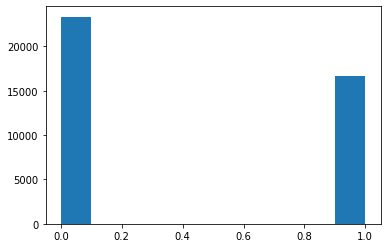

In [38]:
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

train_fine_pid_seq_hospitalized_targets = [obs['hospitalized_three'] for obs in train_fine_pid_seq_hospitalized]

classes = [val for val in range(2)]
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=train_fine_pid_seq_hospitalized_targets)

plt.hist(train_fine_pid_seq_hospitalized_targets)
print(f"Positive class percentage: {sum(train_fine_pid_seq_hospitalized_targets) / len(train_fine_pid_seq_hospitalized_targets)}")
print(f"Class weights: {class_weights}")

out_directory = "./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized"
with open(out_directory + '/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

### Sequence creation (Seven Day Hospitalization Stay Classification)

In [32]:
import os
import pandas as pd
try:
    import cPickle as pickle
except:
    import pickle

# Load data
pid_data_directory = './MIMIC-IV/PID_DEMOGRAPHIC/pid_data_hosp.pkl'
with open(pid_data_directory, 'rb') as f:     # name of hospitalization data is 'pid_data_hosp.pkl'
    pid_data = pickle.load(f)

In [33]:
# Total number of patients
pids = pid_data.subject_id.unique()
len(pids)

256587

In [34]:
# Find recurrent patients
recurrent = pid_data.groupby('subject_id')['hadm_id'].nunique().reset_index()
recurrent = recurrent[recurrent.hadm_id > 1]
recurrent = set(recurrent.subject_id)

In [35]:
import random
from sklearn.model_selection import train_test_split

random.seed(12345)

pretrain_size = int(len(pids) - 50000)
fine_size = int(50000)

_, fine_pids = train_test_split(pids, test_size=fine_size / len(pids), random_state=12345)

It is too slow to do this loop, so we do parallel processing:

In [36]:
%%time
print('Building patients sequences...')
import random
import multiprocessing

def pid_seq_bart_finetune_hosp(pid):
    group = pid_data[pid_data['subject_id'].isin([pid])]
    full_seq = []
    diag_seq = []
    hospitalized_seven = 0
    num_visits = 0

    regexp_dia9 = re.compile(r'DIA9_')
    regexp_dia10 = re.compile(r'DIA10_')

    patient_demographic = " " + group['anchor_age'].unique()[0] + " " + group['marital_status'].unique()[0] + " " + group['ethnicity'].unique()[0] + " " + group['gender'].unique()[0]
    patient_demographic = re.sub(' +', ' ', patient_demographic)

    for time, subgroup in group.sort_values(['dischtime','seq_num'], 
                                            ascending=True).groupby('dischtime', sort=False):
        dischtime = min(subgroup.dischtime)
        admittime = min(subgroup.admittime)
        delta = dischtime - admittime

        if delta.days > 7:
            hospitalized_seven = 1
            break

        num_visits += 1
        code_list = np.array(subgroup['med_code'].drop_duplicates()).tolist()

        if len(code_list) > 1:
            code_lm = ''
            diag_code = ''
            for code in code_list:
                code_lm += code + ' '
                if regexp_dia9.search(code) or regexp_dia10.search(code):
                    diag_code += code + ' '
        else:
            code_lm = code_list[0] + ' '
            diag_code = ''
            if regexp_dia9.search(code_list[0]) or regexp_dia10.search(code_list[0]):
                diag_code += code_list[0] + ' '
            else:
                diag_code += ' '

        code_lm = code_lm[:-1]
        diag_code = diag_code[:-1]
        full_seq.append(code_lm)
        diag_seq.append(diag_code)
    
    visits = ' & '.join(full_seq)
    input_visits = ' & '.join(full_seq)
    output_text = ' & '.join(diag_seq)

    input_text = "PID:" + patient_demographic + " $ " + input_visits

    return {
        'id': pid, 'demographic_info': patient_demographic, 'original_text': visits, 
        'input_text': input_text, 'output_text': output_text, 'hospitalized_seven': hospitalized_seven
        }

# Finetune
with multiprocessing.Pool(processes=24) as pool_obj:
    print('Building finetune patients sequences...')
    fine_pid_seq_hospitalized = pool_obj.map(pid_seq_bart_finetune_hosp, fine_pids)

Building patients sequences...
Building finetune patients sequences...


In [ ]:
fine_pid_seq_hospitalized[0]

{'id': 15373225,
 'demographic_info': ' 29 years old married white female',
 'original_text': 'DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
 'input_text': 'PID: 29 years old married white female $ DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
 'output_text': 'DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
 'hospitalized': 1}

In [ ]:
# Write out the data
out_directory = './MIMIC-IV/PID_DEMOGRAPHIC_Sequences'

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

with open(out_directory + '/fine_pid_seq_hospitalized_7.pkl', 'wb') as f:
    pickle.dump(fine_pid_seq_hospitalized, f, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Load Patient Sequences
out_directory = './MIMIC-IV/PID_DEMOGRAPHIC_Sequences'

with open(out_directory + '/fine_pid_seq_hospitalized_7.pkl', 'rb') as f:
    fine_pid_seq_hospitalized = pickle.load(f)

In [60]:
print('Splitting pretraining and fine-tuning datsets...')
from sklearn.model_selection import train_test_split

# Fine-tune
fine_size = len(fine_pid_seq_hospitalized)

train_fine_pid_seq_hospitalized, val_test_fine_pid_seq_hospitalized = train_test_split(fine_pid_seq_hospitalized, test_size=0.2, random_state=12345)
val_fine_pid_seq_hospitalized, test_fine_pid_seq_hospitalized = train_test_split(val_test_fine_pid_seq_hospitalized, test_size=0.5, random_state=12345)

Splitting pretraining and fine-tuning datsets...


In [61]:
print('Fine-tune datasets:')
print(f'Training size: {len(train_fine_pid_seq_hospitalized)} ({round(len(train_fine_pid_seq_hospitalized) / len(fine_pid_seq_hospitalized), 2) * 100}%)')
print(f'Validation size: {len(val_fine_pid_seq_hospitalized)} ({round(len(val_fine_pid_seq_hospitalized) / len(fine_pid_seq_hospitalized), 2) * 100}%)')
print(f'Testing size: {len(test_fine_pid_seq_hospitalized)} ({round(len(test_fine_pid_seq_hospitalized) / len(fine_pid_seq_hospitalized), 2) * 100}%)')

Fine-tune datasets:
Training size: 40000 (80.0%)
Validation size: 5000 (10.0%)
Testing size: 5000 (10.0%)


In [62]:
import pickle
from tqdm.auto import tqdm

def create_text_seq(data, txt_dir):
    text_data = []
    file_count = 0

    for sample in tqdm(data):
        text_data.append(sample['demographic_info'])
        text_data.append(sample['original_text'])
        if len(text_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(txt_dir):
                os.makedirs(txt_dir)
            with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1
            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:
        with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(text_data)} patients")

def create_pid_seq(data, pid_dir, protocol=pickle.HIGHEST_PROTOCOL):
    pid_data = []
    file_count = 0

    for sample in tqdm(data):

        pid_data.append(sample)

        if len(pid_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(pid_dir):
                os.makedirs(pid_dir)

            with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
                pickle.dump(pid_data, f, protocol=protocol)

            pid_data = []
            file_count += 1

            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:

        with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
            pickle.dump(pid_data, f, protocol=protocol)

        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(pid_data)} patients")

Create training and validation datasets:

In [63]:
# Finetune
create_pid_seq(data=train_fine_pid_seq_hospitalized, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized_7/train")
create_pid_seq(data=val_fine_pid_seq_hospitalized, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized_7/validation")
create_pid_seq(data=test_fine_pid_seq_hospitalized, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized_7/test")

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 15000 patients
Saved 20000 patients
Saved 25000 patients
Saved 30000 patients
Saved 35000 patients
Saved 40000 patients


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 patients


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 patients


Positive class percentage: 0.18085
Class weights: [0.61038882 2.76472215]


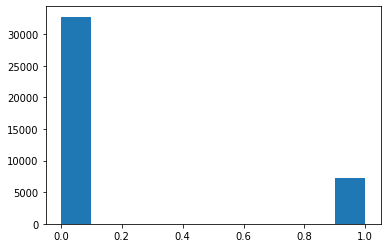

In [20]:
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

train_fine_pid_seq_hospitalized_targets = [obs['hospitalized_seven'] for obs in train_fine_pid_seq_hospitalized]

classes = [val for val in range(2)]
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=train_fine_pid_seq_hospitalized_targets)

plt.hist(train_fine_pid_seq_hospitalized_targets)
print(f"Positive class percentage: {sum(train_fine_pid_seq_hospitalized_targets) / len(train_fine_pid_seq_hospitalized_targets)}")
print(f"Class weights: {class_weights}")

out_directory = "./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_hospitalized_7"
with open(out_directory + '/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

### Sequence creation (Readmission for six and twelve months window frame)

In [ ]:
import os
import pandas as pd
try:
    import cPickle as pickle
except:
    import pickle

# Load data
pid_data_directory = './MIMIC-IV/PID_DEMOGRAPHIC/pid_data_hosp.pkl'
with open(pid_data_directory, 'rb') as f:
    pid_data = pickle.load(f)

In [3]:
# Total number of patients
pids = pid_data.subject_id.unique()
len(pids)

256587

In [113]:
# Find recurrent patients
recurrent = pid_data.groupby('subject_id')['hadm_id'].nunique().reset_index()
recurrent = recurrent[recurrent.hadm_id > 1]
recurrent = set(recurrent.subject_id)

In [114]:
import random
from sklearn.model_selection import train_test_split

random.seed(12345)

pretrain_size = int(len(pids) - 50000)
fine_size = int(50000)

mlm_pids, fine_pids = train_test_split(pids, test_size=fine_size / len(pids), random_state=12345)
train_mlm_pids, val_mlm_pids = train_test_split(mlm_pids, test_size=0.1, random_state=12345)

fine_pids_recurrent = [pid for pid in fine_pids if pid in recurrent]

print(f"Total number of fine-tune examples: {len(fine_pids)}")
print(f"Total number of fine-tune examples with more than one visit: {len(fine_pids_recurrent)}")

Total number of fine-tune examples: 50000
Total number of fine-tune examples with more than one visit: 16638


In [132]:
fine_pid_seq =[]

for pid in fine_pids_recurrent:
    group = pid_data[pid_data['subject_id'].isin([pid])].copy()
    last_admit = np.max(group.admittime)
    full_seq = []
    diag_seq = []
    dischtimes = []

    regexp_dia9 = re.compile(r'DIA9_')
    regexp_dia10 = re.compile(r'DIA10_')

    patient_demographic = " " + group['anchor_age'].unique()[0] + " " + group['marital_status'].unique()[0] + " " + group['ethnicity'].unique()[0] + " " + group['gender'].unique()[0]
    patient_demographic = re.sub(' +', ' ', patient_demographic)

    for time, subgroup in group.sort_values(['dischtime','seq_num'], 
                                            ascending=True).groupby('dischtime', sort=False):
        admittime = np.min(subgroup.admittime)
        if admittime == last_admit:
            break
        dischtime = np.min(subgroup.dischtime)
        
        code_list = np.array(subgroup['med_code'].drop_duplicates()).tolist()

        if len(code_list) > 1:
            code_lm = ''
            diag_code = ''
            for code in code_list:
                code_lm += code + ' '
                if regexp_dia9.search(code) or regexp_dia10.search(code):
                    diag_code += code + ' '
        else:
            code_lm = code_list[0] + ' '
            diag_code = ''
            if regexp_dia9.search(code_list[0]) or regexp_dia10.search(code_list[0]):
                diag_code += code_list[0] + ' '
            else:
                diag_code += ' '

        code_lm = code_lm[:-1]
        diag_code = diag_code[:-1]
        full_seq.append(code_lm)
        diag_seq.append(diag_code)

    visits = ' & '.join(full_seq)
    input_visits = ' & '.join(full_seq)
    output_text = ' & '.join(diag_seq)

    input_text = "PID:" + patient_demographic + " $ " + input_visits

    delta_recall = (last_admit - dischtime) / np.timedelta64(1, 'M')
    six_readmission = 1 if delta_recall < 6 else 0
    twelve_readmission = 1 if delta_recall < 12 else 0

    fine_pid_seq.append({
        'id': pid, 'demographic_info': patient_demographic, 'original_text': visits, 
        'input_text': input_text, 'output_text': output_text, 
        'six_readmission': six_readmission, 'twelve_readmission': twelve_readmission
        }) 

In [140]:
# Write out the data
out_directory = './MIMIC-IV/PID_DEMOGRAPHIC_Sequences/patient_recall'

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

with open(out_directory + '/fine_pid_seq.pkl', 'wb') as f:
    pickle.dump(fine_pid_seq, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load Patient Sequences
out_directory = './MIMIC-IV/PID_DEMOGRAPHIC_Sequences/patient_recall'

with open(out_directory + '/fine_pid_seq.pkl', 'rb') as f:
    fine_pid_seq = pickle.load(f)

In [143]:
fine_pid_seq[:2]

[{'id': 15373225,
  'demographic_info': ' 29 years old married white female',
  'original_text': 'DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
  'input_text': 'PID: 29 years old married white female $ DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
  'output_text': 'DIA10_F339 DIA10_E538 DIA10_Z803 DIA10_Z833 DIA10_Z801 DIA10_Z8249',
  'six_recall': 0,
  'twelve_recall': 0},
 {'id': 15793456,
  'demographic_info': ' 56 years old single black/african american male',
  'original_text': 'DIA9_49322 DIA9_27802 DIA9_4659 DIA9_V5866 DIA9_V1582 DIA9_V8522 DIA9_4011',
  'input_text': 'PID: 56 years old single black/african american male $ DIA9_49322 DIA9_27802 DIA9_4659 DIA9_V5866 DIA9_V1582 DIA9_V8522 DIA9_4011',
  'output_text': 'DIA9_49322 DIA9_27802 DIA9_4659 DIA9_V5866 DIA9_V1582 DIA9_V8522 DIA9_4011',
  'six_recall': 0,
  'twelve_recall': 0}]

In [144]:
print('Splitting pretraining and fine-tuning datsets...')
from sklearn.model_selection import train_test_split

# Fine-tune
fine_size = len(fine_pid_seq)

train_fine_pids, val_test_fine_pids = train_test_split(fine_pids_recurrent, test_size=0.2, random_state=12345)
val_fine_pids, test_fine_pids = train_test_split(val_test_fine_pids, test_size=0.5, random_state=12345)

Splitting pretraining and fine-tuning datsets...


In [147]:
train_fine_pid_seq = [obs for obs in fine_pid_seq if obs['id'] in train_fine_pids ]
val_fine_pid_seq = [obs for obs in fine_pid_seq if obs['id'] in val_fine_pids ]
test_fine_pid_seq = [obs for obs in fine_pid_seq if obs['id'] in test_fine_pids ]

In [148]:
print('Fine-tune datasets:')
print(f'Training size: {len(train_fine_pid_seq)} ({round(len(train_fine_pid_seq) / len(fine_pid_seq), 2) * 100}%)')
print(f'Validation size: {len(val_fine_pid_seq)} ({round(len(val_fine_pid_seq) / len(fine_pid_seq), 2) * 100}%)')
print(f'Testing size: {len(test_fine_pid_seq)} ({round(len(test_fine_pid_seq) / len(fine_pid_seq), 2) * 100}%)')

Fine-tune datasets:
Training size: 13310 (80.0%)
Validation size: 1664 (10.0%)
Testing size: 1664 (10.0%)


Positive rate: 0.5497370398196845
Class weights: [1.11046221 0.90952576]


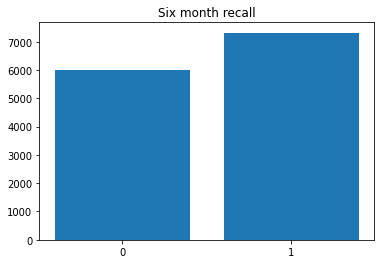

In [162]:
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

six_rec_train_fine_pid_seq = [obs['six_recall'] for obs in fine_pid_seq if obs['id'] in train_fine_pids ]

classes = np.unique(six_rec_train_fine_pid_seq)
y = six_rec_train_fine_pid_seq
class_weights_six = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y)

plt.bar([str(val) for val in classes], [len(six_rec_train_fine_pid_seq) - sum(six_rec_train_fine_pid_seq), sum(six_rec_train_fine_pid_seq)])
plt.title("Six month recall")
plt.show

print(f"Positive rate: {sum(six_rec_train_fine_pid_seq) / len(six_rec_train_fine_pid_seq)}")
print(f"Class weights: {class_weights_six}")

Positive rate: 0.65236664162284
Class weights: [1.43829695 0.76644017]


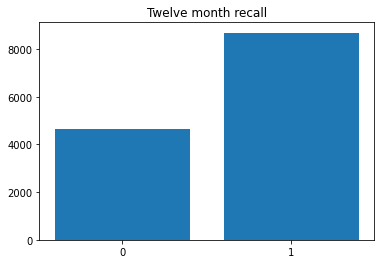

In [163]:
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

twelve_rec_train_fine_pid_seq = [obs['twelve_recall'] for obs in fine_pid_seq if obs['id'] in train_fine_pids ]

classes = np.unique(twelve_rec_train_fine_pid_seq)
y = twelve_rec_train_fine_pid_seq
class_weights_twelve = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y)

plt.bar([str(val) for val in classes], [len(twelve_rec_train_fine_pid_seq) - sum(twelve_rec_train_fine_pid_seq), sum(twelve_rec_train_fine_pid_seq)])
plt.title("Twelve month recall")
plt.show

print(f"Positive rate: {sum(twelve_rec_train_fine_pid_seq) / len(twelve_rec_train_fine_pid_seq)}")
print(f"Class weights: {class_weights_twelve}")

In [172]:
# Write out the data
out_directory = './MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_recall'

if not os.path.exists(out_directory):
    os.makedirs(out_directory)

with open(out_directory + '/class_weights_six.pkl', 'wb') as f:
    pickle.dump(class_weights_six, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(out_directory + '/class_weights_twelve.pkl', 'wb') as f:
    pickle.dump(class_weights_twelve, f, protocol=pickle.HIGHEST_PROTOCOL)

In [176]:
import pickle
from tqdm.auto import tqdm

def create_text_seq(data, txt_dir):
    text_data = []
    file_count = 0

    for sample in tqdm(data):
        text_data.append(sample['demographic_info'])
        text_data.append(sample['original_text'])
        if len(text_data) == 5000:
            # once we hit the 5K mark, save to file
            if not os.path.exists(txt_dir):
                os.makedirs(txt_dir)
            with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1
            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:
        with open(f'{txt_dir}/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(text_data)} patients")

def create_pid_seq(data, pid_dir, protocol=pickle.HIGHEST_PROTOCOL):
    pid_data = []
    file_count = 0
    
    if not os.path.exists(pid_dir):
        os.makedirs(pid_dir)

    for sample in tqdm(data):

        pid_data.append(sample)

        if len(pid_data) == 5000:
            # once we hit the 5K mark, save to file

            with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
                pickle.dump(pid_data, f, protocol=protocol)

            pid_data = []
            file_count += 1

            print(f"Saved {5000 + (5000 * (file_count - 1))} patients")

    if (len(data) % 5000) != 0:

        with open(f'{pid_dir}/pids_{file_count}.pkl', 'wb') as f:
            pickle.dump(pid_data, f, protocol=protocol)

        print(f"Saved {5000 + (5000 * (file_count - 1)) + len(pid_data)} patients")

Create training and validation datasets:

In [177]:
# Finetune
create_pid_seq(data=train_fine_pid_seq, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_recall/train")
create_pid_seq(data=val_fine_pid_seq, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_recall/validation")
create_pid_seq(data=test_fine_pid_seq, pid_dir="./MIMIC-IV/PID_DEMOGRAPHIC_Sequences/Finetune_recall/test")

  0%|          | 0/13310 [00:00<?, ?it/s]

Saved 5000 patients
Saved 10000 patients
Saved 13310 patients


  0%|          | 0/1664 [00:00<?, ?it/s]

Saved 1664 patients


  0%|          | 0/1664 [00:00<?, ?it/s]

Saved 1664 patients


# Implemented by Diego Saenz